In [172]:
import matplotlib
import numpy as np
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes', titlesize=15)
matplotlib.rc('axes', labelsize=15)
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from scipy.optimize import differential_evolution
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
from random import randint
import dissertation_codes.utils.constants as ct


In [175]:
def closed_loop(t, dt, x, omega, gamma, epsilon, adapt_gain, kp, kd, noise_std):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    dx1dt = x2; 
    dx2dt = -gamma*x2-np.power(omega,2)*x1-epsilon*np.power(x1,3)+x3*np.power(x1,3)-kp*x1-kd*x2+noise_std*np.sqrt(1/dt)*np.random.normal()
    dx3dt = -adapt_gain*np.power(x1,3)*x2
    return np.array([dx1dt,dx2dt,dx3dt])

def solve_equation(x, t, delta_t, omega, gamma, epsilon, adapt_gain, kp, kd, noise_std):
    x_plot = []
    for i in range(t.size):
        k1 = closed_loop(t[i],delta_t, x, omega, gamma, epsilon, adapt_gain, kp, kd,  noise_std)
        k2 = closed_loop(t[i] + 0.5*delta_t, delta_t,  x + 0.5*delta_t*k1, omega, gamma, epsilon, adapt_gain, kp, kd, noise_std)
        k3 = closed_loop(t[i] + 0.5*delta_t, delta_t, x + 0.5*delta_t*k2, omega, gamma, epsilon, adapt_gain, kp, kd, noise_std)
        k4 = closed_loop(t[i] + delta_t, delta_t, x + delta_t*k3, omega, gamma, epsilon, adapt_gain, kp, kd, noise_std)
        x = x + (delta_t/6)*(k1+2*k2+2*k3+k4)
        x_plot.append(x)
    return np.array(x_plot)




In [177]:
gamma = 10000
omega = 2*np.pi*81e3
period = 2*np.pi/omega
delta_t = 1e-7
t = np.arange(0, 4*period, delta_t)
epsilon = 10*np.power(omega,2)
adapt_gain = 1000
kp = 5000
kd = 100000
m = 2200*4*np.pi*np.power(71.5e-9,3)/3
noise_std = np.sqrt(2*gamma*293*ct.kb/m)

x0 = np.array([10, 10, omega])

x = solve_equation(x0, t, delta_t, omega, gamma, epsilon, adapt_gain, kp, kd, noise_std)
x_linear = solve_equation(x0, t, delta_t, omega, gamma, epsilon, 0, kp, kd, noise_std)

<a name='1'></a> 
### 1. Packages and imports

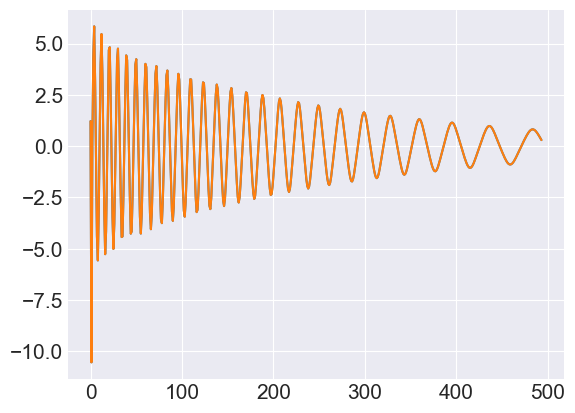

In [178]:
plt.plot(x[:,0])
plt.plot(x_linear[:,0])

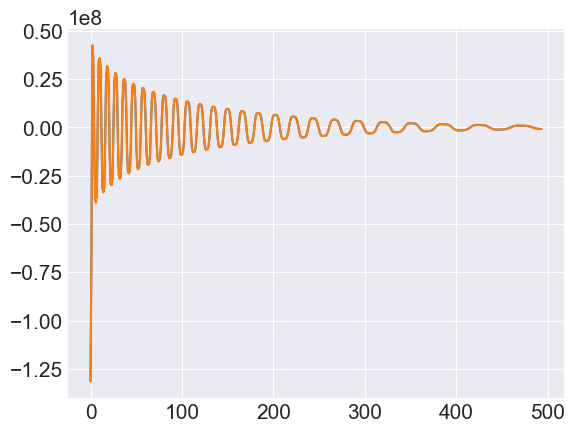

In [171]:
plt.plot(x[:,1])
plt.plot(x_linear[:,1])

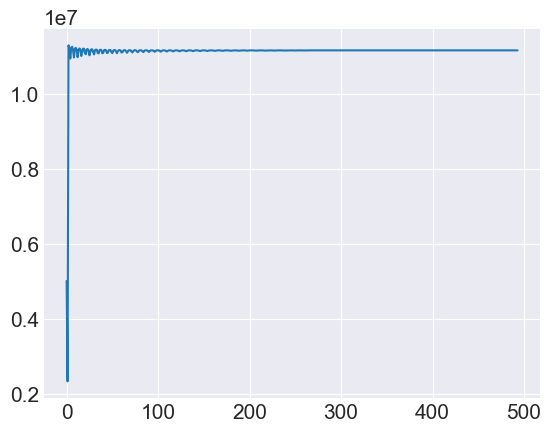

In [159]:
plt.plot(x[:,2])
#plt.plot(x_linear[:,2])
#plt.plot(epsilon*np.ones(x[:,2].shape))

<a name='2'></a> 
### 2. Creating the virtual nano-particle

Here we are going to define some parameters for simulations. First, the particle frequency $f$, from this, we know the period $T$ and the angular frequency $\omega$. The period is going to be used to define the maximum simulation time $t_{max}$. The parameter $M$ represents the number of traces that are going to be created, we will simulate two different gains $G_1=6\times 10^5 \,\textrm{N/m}^3$ and $G_2=2\times 10^5 \,\textrm{N/m}^3$. For this simulation the $\gamma$ used was $66\times 10^3 \textrm{s}^{-1}$.

In [3]:
freq_x = 63.10e3
freq_y = 70.24e3
freq_z = 15.79e3
omega_x = 2*np.pi*freq_x
omega_y = 2*np.pi*freq_y
omega_z = 2*np.pi*freq_z

T = 1 / freq_y
R = 143e-9/2
P = 1e2
max_time = 500 * T
M = 10
delta_t = 2e-7
N_time = int(max_time / delta_t)
t = np.linspace(0, max_time, int(N_time))
gamma = compute_gamma(R, P)

In [21]:
max_time*50

0.35592255125284744

In [10]:
env_x = Particle(omega_x, gamma, radius=R)
env_y = Particle(omega_y, gamma, radius=R)
env_z = Particle(omega_z, gamma, radius=R)

<a name='3'></a> 
### 3. Generating traces

To create the traces we will call a function from our package, the `simulation` will run the Euler-Maruyama algorithm using Numba, this will allow for an optimized run, reducing time consumption. We also defined a `psd` function to run the `welch` method from `scipy.signal` on dictionary of traces.

In [11]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs)


def generate_traces(env, delta_t, N_time,  M):
    traces = np.zeros(shape=(M, N_time))
    for i in range(M):
        data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, 0, 0)
        data = np.array(data)
        traces[i, :] = data
    freq, pxx = psd(env.zp_x*traces, delta_t)
    return env.zp_x*traces, pxx.mean(axis=0), freq

In [15]:
def lorentzian(omega_array, m, omega, gamma, T=293):
    return (2*gamma*ct.kb*T/m)*(1/(np.power(np.power(omega_array,2)-np.power(omega,2),2)+np.power(omega_array*gamma,2)))

In [16]:
omegas = np.linspace(0, 2*np.pi*1e5, int(1e4))
fit_x = lorentzian(omegas, env_x._m_, omega_x, gamma)
fit_y = lorentzian(omegas, env_x._m_, omega_y, gamma)
fit_z = lorentzian(omegas, env_x._m_, omega_z, gamma)

In [17]:
traces_x, p_xx, freq  = generate_traces(env_x, delta_t, N_time, M)
traces_y, p_yy, freq  = generate_traces(env_y, delta_t, N_time, M)
traces_z, p_zz, freq  = generate_traces(env_z, delta_t, N_time, M)

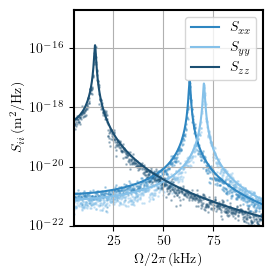

In [18]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(3.5*factor, 4*factor, forward=True)

plt.scatter(freq/1e3, p_xx, color=colors[0], s=1, alpha=0.3)
plt.plot(omegas/(2*np.pi*1e3), np.sqrt(2*np.pi)*fit_x, color=colors[0])
plt.scatter(freq/1e3, p_yy, color=colors[1], s=1, alpha=0.3)
plt.plot(omegas/(2*np.pi*1e3), np.sqrt(2*np.pi)*fit_y, color=colors[1])
plt.scatter(freq/1e3, p_zz, color=colors[2], s=1, alpha=0.3)
plt.plot(omegas/(2*np.pi*1e3), np.sqrt(2*np.pi)*fit_z, color=colors[2])
plt.yscale('log')
plt.xlabel(r'$\Omega/2\pi \,(\textrm{kHz})$')
plt.ylabel(r'$S_{ii} \,(\textrm{m}^2/\textrm{Hz})$')
plt.xlim([5, 100])
plt.ylim([1e-22, 2e-15])
plt.xticks([25, 50, 75])
plt.legend([r'$S_{xx}$', r'$S_{yy}$', r'$S_{zz}$'])
plt.grid()
plt.savefig('../../plots/Chapter 2/psds.pdf', dpi=300, bbox_inches = 'tight')

plt.show()



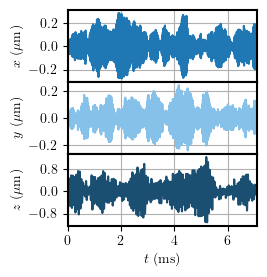

In [20]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
factor = 0.7
fig.set_size_inches(3.5*factor, 4*factor, forward=True)


ax1.plot(t[::10]/1e-3, traces_x[0,:][::10]/1e-6)

ax1.set_xlim([0, t.max()/1e-3])
ax1.set_yticks([-0.2,0,0.2])
ax1.grid(True, which="both", ls="-")
ax1.set_ylabel(r'$x$ $(\mu \textrm{m})$')


ax2.plot(t[::10]/1e-3, traces_y[0,:][::10]/1e-6, color=colors[1])
ax2.set_ylabel(r'$y$ $(\mu \textrm{m})$')
ax2.grid(True, which="both", ls="-")
ax2.set_yticks([-0.2,0,0.2])


ax3.plot(t[::10]/1e-3, traces_z[0,:][::10]/1e-6, color=colors[2])
ax3.set_yticks([-0.8,0,0.8])
ax3.set_ylabel(r'$z$ $(\mu \textrm{m})$')
ax3.set_xlabel(r'$t$ (ms)')
plt.subplots_adjust(wspace=0, hspace=0)

plt.grid()
plt.savefig('../../plots/Chapter 2/traces.pdf', dpi=300, bbox_inches = 'tight')
plt.show()


<a name='4'></a> 
### 4. Plots and comparison with theoretical predictions

Here we will define the autocorrelation functions, both zero and first order corrections. This will be used to compared the theory with simulation, which will be done in the last cell, via the plots that will be saved under the name `area_ratio_vs_delay.png`.


In [9]:
def autocor_0(t, omega, gamma, m= 3.368e-18, T = 293):
    C = 2*(gamma*ct.kb*T/m)
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18, T = 293):
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*ct.kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -3*C*C*b*mult*(part1+part2+part3+part4)
    return T0+T1

In [10]:
theory_delays = np.linspace(0, T, 100)
areas_1 = autocor_perturbation(0, env.__omega__, env.__gamma__, -gain1/env._m_, theory_delays, m=env._m_)
areas_2 = autocor_perturbation(0, env.__omega__, env.__gamma__, -gain2/env._m_, theory_delays, m=env._m_)

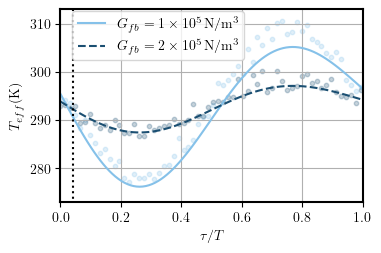

In [11]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
fig.set_size_inches(3*1.3, 2.5, forward=True)

plt.plot(theory_delays/T, 0.5*(ct.hbar*2*np.pi/(ct.kb*T))*(areas_1/(env.zp_x**2)-1/2), color=colors[1], label=r"$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")
plt.scatter(delta_t*np.array(delay_range)/T, 0.5*(ct.hbar*2*np.pi/(ct.kb*T))*(np.array(areas_gain1)*np.diff(freq)[0]-1/2),s=10, color=colors[1], alpha=0.25, label=r"_$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")


plt.plot(theory_delays/T, 0.5*(ct.hbar*2*np.pi/(ct.kb*T))*(areas_2/(env.zp_x**2)-1/2), color=colors[2], label=r"$G_{fb}=2\times 10^5\,\textrm{N/m}{}^3$", linestyle='dashed')
plt.scatter(delta_t*np.array(delay_range)/T, 0.5*(ct.hbar*2*np.pi/(ct.kb*T))*np.array(areas_gain2)*np.diff(freq)[0]-1/2,s=10, color=colors[2], alpha=0.25, label=r"_$G_{fb}=5.9\times 10^5\,\textrm{N/m}{}^3$")

plt.xlabel(r'$\tau/T$')
plt.ylabel(r'$T_{eff} (\textrm{K})$')
plt.plot([5e-7/T, 5e-7/T], [0, 315], linestyle='dotted', color='black')
plt.ylim([273, 313])
plt.xlim([0, 1])
plt.legend(bbox_to_anchor=(0.016, 0.7, 1., .102))
plt.grid()
plt.savefig('../plots/area_ratio_vs_delay.png',dpi=300, bbox_inches = 'tight')